# Using the `database_wide_monte_carlo` code to generate samples

Pascal Lesage, CIRAIG  
March 2017

For best viewing pleasure, use the `Table of Contents (2)` [Notebook extension](http://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html).

-----------

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Summary-of-steps" data-toc-modified-id="Summary-of-steps-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Summary of steps</a></span></li><li><span><a href="#More-details" data-toc-modified-id="More-details-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>More details</a></span><ul class="toc-item"><li><span><a href="#Installing-Brightway2" data-toc-modified-id="Installing-Brightway2-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Installing <code>Brightway2</code></a></span></li><li><span><a href="#Setting-up" data-toc-modified-id="Setting-up-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Setting up</a></span></li><li><span><a href="#Generating-the-samples" data-toc-modified-id="Generating-the-samples-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generating the samples</a></span><ul class="toc-item"><li><span><a href="#General-description" data-toc-modified-id="General-description-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>General description</a></span></li><li><span><a href="#Organization-of-the-sampling:-base_directory,-database-directory,-jobs-directory,-jobs,-iterations" data-toc-modified-id="Organization-of-the-sampling:-base_directory,-database-directory,-jobs-directory,-jobs,-iterations-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Organization of the sampling: base_directory, database directory, jobs directory, jobs, iterations</a></span></li><li><span><a href="#Running-the-code" data-toc-modified-id="Running-the-code-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Running the code</a></span></li><li><span><a href="#Checking-out-the-output:" data-toc-modified-id="Checking-out-the-output:-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Checking out the output:</a></span></li></ul></li><li><span><a href="#Cleaning-up-the-samples" data-toc-modified-id="Cleaning-up-the-samples-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Cleaning up the samples</a></span></li><li><span><a href="#Concatenating-results-within-jobs" data-toc-modified-id="Concatenating-results-within-jobs-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Concatenating results within jobs</a></span></li><li><span><a href="#Concatenating-results-across-jobs" data-toc-modified-id="Concatenating-results-across-jobs-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Concatenating results across jobs</a></span></li><li><span><a href="#Generating-LCIA-score-arrays" data-toc-modified-id="Generating-LCIA-score-arrays-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Generating LCIA score arrays</a></span></li><li><span><a href="#Final-structure" data-toc-modified-id="Final-structure-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Final structure</a></span></li></ul></li><li><span><a href="#A-note-on-size" data-toc-modified-id="A-note-on-size-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>A note on size</a></span></li></ul></div>

## Introduction

The code in the `DatabaseWideMonteCarlo` package can be used to generate precalculated sample arrays for a whole LCI database. The code can be used to calculate arrays for:  
  - The technosphere matrix $\mathbf{A}$ and the elementary flow matrix $\mathbf{B}$ (called the biosphere matrix in Brightway2)
  - Supply arrays $\mathbf{s}$ for unit demands of each activity (i.e. how much each unit process needs to produce to meet a unit of demand for any activity in the database)  
  - Inventory arrays $\mathbf{g}$ for unit demands of each activity, functionaly equivalent to aggregated datasets  
  - LCIA score arrays $\mathbf{h}$ for unit demands of each activity  
  
For any of these, the principle is the same:  
  - each **row** of the precalculated sample arrays represents a specific object (an input to a given activity, an emission to air, an LCIA score)  
  - each **column** refers to a given Monte Carlo iteration. All arrays have the same number of columns, and each column in any of the arrays was generated with the same Monte Carlo iteration, i.e. with the same initial data in the technosphere and biosphere matrix. 
  
These can then be reused for efficient uncertainty analyses in LCA.

## Summary of steps

The steps, detailed below, to produce the arrays are as follows:  

The steps to a typical usage are:  

- [Install](https://docs.brightwaylca.org/installation.html) the [Brightway2 life cycle assessment framework](http://brightwaylca.org/).   


- Set up the Brightway project and import the database. This can be done by running the `setup.py` file. The setup file assumes you are importing ecoSpold2 files. For another type of database, modify `setup.py` so it uses another `importer`, or simply setup the Brightway2 environment yourself. If you already have a project with the target LCI database, this step is skipped.

  ``python setup.py --project_name=my_project, --ecospold_dirpath=my_path_to_folder_with_ecospold2_files --database_name=db'`


- Dependently generate individual samples using the `sample_generation.py` file. This process can be halted and restarted, can be distributed across many computers, and relies on multiprocessing to speed up Monte carlo simulations. The results generated in one batch are found in `job` directories. 

  ``python sample_generation.py --project_name=my_project --database_name=db --iterations=1000 --cpus=8 --base_dir=path_to_my_folder --include_inventory=True --include_supply=True --include_matrices=True``


- Sanitize results using `clean_jobs.py`. This will delete jobs or iterations within a job that are missing information. 

  ``python clean_jobs.py --base_dir=path_to_my_folder --database_name=db --database_size=14889 --include_inventory=True --include_matrices=True --include_supply=True``


- Concatenate results within a job with `concatenate_within_jobs.py`. Uses multiprocessing to speed up process, but is nonetheless a **very** lengthy task.

  ``python concatenate_within_jobs.py --base_dir=path_to_my_folder --database_name=db --include_inventory=True --include_matrices=True --include_supply=True --cpus=8 --delete_raw_files=True``


- Concatenate results across jobs using `concatenate_across_jobs.py`. At this point, results can include (depending on what arguments were passed to the former functions) **A** and **B** matrix results, supply arrays **s**, cradle-to-gate inventories **g**. By design, they all have the same number of columns, and the i*th* column in any array is based on the same Monte Carlo iteration.  

  ``python across_jobs.py --base_dir=path_to_my_folder --database_name=db --project=my_project --include_inventory=True --include_matrices=True --include_supply=True --cpus=8 --delete_temps=True``


- Generate LCIA scores from the LCI results using `calculate_LCIA.py`. LCIA score arrays will be generated for all methods specified in a list saved to base_dir/database_name/results/reference_files/methods.pickle, or all methods implemented in Brightway2 if file doesn't exist.  

  ``python calculate_LCIA.py --base_dir=path_to_my_folder --database_name=db --project=my_project --cpus=8``  
  
What you end up with at the end of these steps depends on the arguments you have used (especially the `delete_x` and the `include_y`) arguments. See other notebooks in this repo to see two examples of how these can be used.

## More details

Following the recipe above is sufficient to use the package. If you want more details about what each file does, then read on.

### Installing `Brightway2`

The code to generate of pre-calculated Monte Carlo samples for the *ecoinvent v3.4 cut-off by classification* database uses the Python-based open-source [Brightway2 framework](https://brightwaylca.org/). Brightway2 is specifically developped for developping LCA programs: it has optimized calculation routines, many LCA-related functions and allows access to many intermediate objects in the LCA calculation chain.  
There is a series of online tutorial Notebooks available [here](https://github.com/PoutineAndRosti/Brightway-Seminar-2017) for learning the basics of using Brightway2.

The process of installing Brightway2 are detailed [here](https://docs.brightwaylca.org/installation.html). An installation of Brightway2 is required to use this package.

### Setting up

To get started, you need to have the following:  
- A Brightway project with the `biosphere3` database (which contains information about elementary flows) and LCIA methods  
- An LCI database.  

The `setup.py` file simply combines the sequence of functions required to have these objects ready. 

It (and other functions in this package) uses the [`click` library](http://click.pocoo.org/5/) to be able to pass arguments to the python functions directly from the command line.   
To run it, simply navigate (`cd`) to the directory where it is stored and run the following command:  

`python setup.py --project_name=my_project, --ecospold_dirpath=my_path_to_folder_with_ecospold2_files --database_name=db`  

where:  

  * **'project_name'** is simply the name of your project. This name can be any string.  
  * **'ecospold_dirpath'** is the file path to the folder where the ecoSPold2 files are found. Note that this assumes you are importing an ecoinvent v3.x database. If this is not the case, then change the `setup.py` file to use another [`Importer`](https://bitbucket.org/cmutel/brightway2-io/src/ee2296d41063a0e45e1edfb18ca88f5be7d46999/bw2io/importers/?at=default), or simply pass the series of commands yourself to import the database in your project.  
  * **'database_name'** is simply the name the database will have within the project. 
  
**Note**: The `click` library does not handle whitespace well - preferably use project and database names with no whitespace.  

**Note on obtaining the ecoSpold files from ecoQuery**
A valid ecoinvent licence gives access to the download of the entire database in ecoSpold2 format. 
These are found on the ecoQuery website, in the "files" section. They are zipped using the [7z format](http://www.7-zip.org/).  
The ecoSpold2 formats should represent "Single Output Unit Processes", which are generated from the "undefined" unit processes using a set of linking rules. Linking rules basically state how multifunctional processes are to be dealt with and how suppliers are identified during unit process linking (e.g. average vs. marginal supplier). 
The ecoinvent Center has three set of rules: 
- Allocation, cut-off by classification (used in this project)  
- Allocation at the point of substitution  
- Substitution, consequential, long-term  

For more information, see [here](https://www.ecoinvent.org/database/system-models-in-ecoinvent-3/system-models-in-ecoinvent-3.html).  

For this example, the ecoinvent v3.4 cut-off by classification database is used.

For now, let's execute the code directly from within the Notebook using the [`%run` magic command](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-run).

In [1]:
# Move to directory containing code
import os
os.chdir(r'C:/mypy/code/database_wide_monte_carlo')

In [2]:
# Use the IPython magic %run to run the file from within the Jupyter Notebook
# Normally, this would be done from the command line
# in an environment where Brightway2 is installed
%run setup.py --project_name=my_mcs --ecospold_dirpath=C:\mypy\data\ecoinvent_spolds\ecoinvent34\datasets --database_name=db --overwrite_database=False

Created project my_mcs
Creating default biosphere



Writing activities to SQLite3 database:
0%                          100%
[#####                         ] | ETA: 00:00:00

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applied 2 strategies in 0.01 seconds


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/20/2018 16:37:43
  Finished: 03/20/2018 16:37:43
  Total time elapsed: 00:00:00
  CPU %: 53.50
  Memory %: 0.89
Created database: biosphere3
Creating default LCIA methods

Applying strategy: normalize_units
Applying strategy: set_biosphere_type
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_iterable_by_fields
Applied 4 strategies in 0.97 seconds
Wrote 718 LCIA methods with 178008 characterization factors
Creating core data migrations

Extracting XML data from 14889 datasets
Extracted 14889 datasets in 83.09 seconds
Applying strategy: normalize_units
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspec

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:02:07


Title: Writing activities to SQLite3 database:
  Started: 03/20/2018 16:40:41
  Finished: 03/20/2018 16:42:48
  Total time elapsed: 00:02:07
  CPU %: 45.30
  Memory %: 6.68
Created database: db


### Generating the samples

#### General description

The main idea behind the pre-calculated samples is that, for a given iteration, the same random values for the technosphere matrix $\mathbf{A}$ and the elementary flow matrix $\mathbf{B}$ (called the *biosphere* matrix in Brightway2) are used to solve the LCA problem for all possible products in the database. This ensures that all product LCI and LCIA scores are based on the same *realization* of the input matrices, i.e. they are correlated.  
Given this, the general algorithm is quite simple. For a given iteration:
  - for every iteration:  
    - Create a new directory  
    - Store, if requested, the $\mathbf{A}$ and $\mathbf{B}$ matrices in a subdirectory (Matrices). These can later be used in e.g. sensitivity analysis or to reproduce results. The saved matrices are stored not used in calculations. These are saved in three [numpy arrays](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.array.html) required to build scipy sparse matrices of the type [Compressed Sparse Row](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html):
      - `data`, the actually sampled values for non-zero elements of the matrices. There is one of these per iteration, and it is found in the `Matrices` folder. They are simply named `A_matrix.npy` of `B_matrix.npy`. 
      - `X_row_indices`, where the *i*th element indicates in what row of the corresponding matrix **X** the *i*th element of the `data` file is located.  
      - `X_col_indices`, where the *i*th element indicates in what column of the corresponding matrix **X** the *i*th element of the `data` file is located.  

    - For every product in the database:    
      - Calculate, and store if requested,  the supply vector $\mathbf{s}$ for a unit demand of the product, i.e. the vector that contains the required output from each unit process in the database. These are also [saved](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.save.html) as [numpy arrays](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.array.html). The file names are also equal to the activity's UUID.    
      - Calculate and store, if requested, the LCI vector $\mathbf{g}$, i.e. the vector that contains the total amounts of elementary flows per unit output of the product. These arealso saved as numpy arrays, and their names also correspond to the activity's [code](https://docs.brightwaylca.org/intro.html#activity-hashes).  
            
This will generate one directory per iteration, with as many subdirectories as there were requested objects (matrices, supply arrays, life cycle inventories).  
- The subdirectories `Inventory` and `Supply` contain, if their respective objects are requested, as many files as there are products in the database (14889 in the case of ecoinvent 3.4 cut-off)  
- The subdirectory `Matrices` contains two files with the data for the $\mathbf{A}$ and $\mathbf{B}$ matrices. The row and column indices are the same across all iterations, and so are stored in the job-level folder `common_files` (see below). 


#### Organization of the sampling: base_directory, database directory, jobs directory, jobs, iterations  

- Everything that is generated by this code (and subsequent functions) is stored in a base directory, referred to as **`base_dir`** in the code. In this example, we will use `C:\mypy\data\myMCs` 
- It is assumed that a user could want to store results for multiple databases in the same base directories. Therefore, for a given database, a new subdirectory named after the treated database is generated.  
- Within this directory, a new subdirectory called **`jobs`** is created. This directory holds temporary items, notably the millions of small saved numpy arrays that will later be concatenated to be reused. Once everything has been processed, these can safely be deleted. There are helper functions to delete these as they become obsolete.  
- The sampling and calculation of LCI results can be a lengthy process, so a user may want to launch and break (`ctrl-c`) the code multiple times, or run the code from many computers at once, only to later join the results. A session of work between the time the code is launched and the time it either finished (calculated and stored results for all iterations) or was halted is called a **`job`**, and each job has its own directory.  
- Within each `job` directory, one finds subdirectories for each **iteration**, as described above.  
- Each time a new job is launched, a number of **common files** that will help knowing what are in the arrays, and in what order. These files are:  

  - **`activity_UUIDs.json`**: list of activity codes, in the order in which they were processed. Activity codes are UUIDs and are the second element of activity *keys*, (database_name, activity_code)  
  - **`activity_dict.pickle`**: dictionary where keys are the tuples that uniquely identify the activities (database_name, UUID) and the values are the column numbers of these activities in the $\mathbf{A}$ and $\mathbf{b}$ matrices (or the index in the supply vector $\mathbf{s}$).  
  - **`bio_col_indices.npy`, `bio_row_indices.npy`**: Arrays with the column and row indices of the matrix data arrays for the $\mathbf{b}$ matrix, , respectively, used to build a `COO` matrix and to link data to matrix elements (using the `rev_activity_dict`and `rev_bio_dict`, respectively) 
  - **`bio_dict.pickle`**: dictionary where keys are the tuples that uniquely identify the elementary flows ('biosphere3', UUID) and the values are the row numbers of these activities in the $\mathbf{B}$ matrices (or the index in the inventory vector $\mathbf{g}$).  
  - **`bio_params.pickle`**: Information about each individual elementary flow in the $\mathbf{B}$ matrix in the form of a [parameter array](https://docs.brightwaylca.org/lca.html#building-matrices). This file is never used by the subsequent functions.    
  - **`IO_Mapping.pickle`**: Mapping of exchanges to the indices in the SQL inventory database in the project. This file is never used by the subsequent functions.    
  - **`product_dict.pickle`**: dictionary where keys are the tuples that uniquely identify the products (database_name, UUID) and the values are the row numbers of these products in the $\mathbf{A}$ matrix.  
  - **`tech_col_indices.npy`, `tech_row_indices.npy`**: Arrays with the column and row indices of the matrix data arrays for the $\mathbf{A}$ matrix, , respectively, used to build a `COO` matrix and to link data to matrix elements (using the `rev_activity_dict`and `rev_product_dict`, respectively) 
  - **`tech_params.pickle`**: Information about each individual elementary flow in the $\mathbf{A}$ matrix in the form of a [parameter array](https://docs.brightwaylca.org/lca.html#building-matrices). This file is never used by the subsequent functions.

The resulting structure is therefore, for *n* datasets and *m* iterations:  
```bash  
  |-- base_dir   
  |   |-- database      
  |   |   |-- jobs   
  |   |   |   |-- job_1  
  |   |   |   |   |-- common_files  
  |   |   |   |   |   |-- ...11 common files described above
  |   |   |   |   |-- Iteration_0
  |   |   |   |   |   |-- Matrices
  |   |   |   |   |   |   |-- A_matrix.npz  
  |   |   |   |   |   |   |-- B_matrix.npz
  |   |   |   |   |   |-- Inventory
  |   |   |   |   |   |   |-- UUID_1.npy
  |   |   |   |   |   |   |-- UUID_2.npy  
  |   |   |   |   |   |   |-- ...
  |   |   |   |   |   |   |-- UUID_n.npy    
  |   |   |   |   |   |-- Supply
  |   |   |   |   |   |   |-- UUID_1.npy
  |   |   |   |   |   |   |-- UUID_2.npy  
  |   |   |   |   |   |   |-- ...
  |   |   |   |   |   |   |-- UUID_n.npy    
...
  |   |   |   |   |-- Iteration_m
  |   |   |   |   |   |...
  |   |   |   |-- job_2  
  |   |   |   |   |-- common_files  
  |   |   |   |   |   |-- ...11 common files described above
  |   |   |   |   |-- Iteration_0
  |   |   |   |   |   |...
  |   |   |   |   |-- Iteration_m
```

#### Running the code

The code to generate the pre-calculated samples are found in `sample_generation.py`  
It uses `multiprocessing` to speed up calculations: iterations are dispatched to individual CPUs.  

The passed arguments are:  
- **`project_name`**: Name of the Brightway2 project (string).
- **`database_name`**: Name of the database for which samples are required (string).
- **`iterations`**: Number of Monte Carlo iterations to carry out (integer).
- **`cpus`**: Number of CPUs to use in Monte Carlo generation. Because calculations are done in parallel, more CPUs=less time.
- **`base_dir`**: Base directory path for precalculated samples
- **`include_matrices`**, **`include_supply`**, **`include_inventory`**: Requested elements for which samples should be saved (bool)

Let's generate two jobs of 5 iterations each, requesting all of the possible outputs.  

In [3]:
%run sample_generation.py --project_name=my_mcs --database_name=db --iterations=1 --cpus=8 --base_dir=C:/mypy/data/my_mcs --include_matrices=True --include_supply=True --include_inventory=True


1 samples generated for 14889 activities, saved to directory C:/mypy/data/my_mcs\db\jobs\DESKTOP-KUE8133_2018-3-20_16h43.
Use `clean_jobs.py` to sanitize the data, and then `concatenate_within_jobs.py` to consolidate samples
See log file for more information


In [4]:
%run sample_generation.py --project_name=my_mcs --database_name=db --iterations=1 --cpus=8 --base_dir=C:/mypy/data/my_mcs --include_matrices=True --include_supply=True --include_inventory=True

1 samples generated for 14889 activities, saved to directory C:/mypy/data/my_mcs\db\jobs\DESKTOP-KUE8133_2018-3-20_16h49.
Use `clean_jobs.py` to sanitize the data, and then `concatenate_within_jobs.py` to consolidate samples
See log file for more information


In [19]:
%run sample_generation.py --project_name=my_mcs --database_name=db --iterations=8 --cpus=8 --base_dir=C:/mypy/data/my_mcs --include_matrices=True --include_supply=True --include_inventory=True

8 samples generated for 14889 activities, saved to directory C:/mypy/data/my_mcs\db\jobs\DESKTOP-KUE8133_2018-3-20_17h41.
Use `clean_jobs.py` to sanitize the data, and then `concatenate_within_jobs.py` to consolidate samples
See log file for more information


In [20]:
%run sample_generation.py --project_name=my_mcs --database_name=db --iterations=5 --cpus=8 --base_dir=C:/mypy/data/my_mcs --include_matrices=True --include_supply=True --include_inventory=True

5 samples generated for 14889 activities, saved to directory C:/mypy/data/my_mcs\db\jobs\DESKTOP-KUE8133_2018-3-20_17h56.
Use `clean_jobs.py` to sanitize the data, and then `concatenate_within_jobs.py` to consolidate samples
See log file for more information


#### Checking out the output:

The program first created `base_dir`, a directory where everything will be stored, and a subdirectory `db` where all the work for this specific database will be stored. Within the database-level directory, there is only one subdirectory for now: `jobs`:

In [21]:
base_dir = r'C:/mypy/data/my_mcs'
database_name = 'db'
os.listdir(os.path.join(base_dir, database_name))

['jobs', 'results']

Inside the jobs directory, we find the two jobs we ran:

In [22]:
jobs = os.listdir(os.path.join(base_dir, database_name, 'jobs'))
jobs

['DESKTOP-KUE8133_2018-3-20_16h43',
 'DESKTOP-KUE8133_2018-3-20_16h49',
 'DESKTOP-KUE8133_2018-3-20_17h41',
 'DESKTOP-KUE8133_2018-3-20_17h56']

Looking inside the first job, we find directories for our `common_files` and our five iterations, as wel as a small log file that just states what was generated and when:  

In [23]:
# Common files: 
job1_dir = os.path.join(base_dir, database_name, 'jobs', jobs[0])
os.listdir(job1_dir)

['common_files', 'concatenated_arrays', 'iteration_0-0', 'log.json']

The common files are as announced:

In [24]:
os.listdir(os.path.join(job1_dir, 'common_files'))

['activity_dict.pickle',
 'activity_UUIDs.json',
 'bio_col_indices.npy',
 'bio_dict.pickle',
 'bio_params.pickle',
 'bio_row_indices.npy',
 'IO_Mapping.pickle',
 'product_dict.pickle',
 'tech_col_indices.npy',
 'tech_params.pickle',
 'tech_row_indices.npy']

Inside the iterations subdirectories, we have our three expected subdirectories:  

In [25]:
os.listdir(os.path.join(job1_dir, 'iteration_0-0'))

['Inventory', 'Matrices', 'Supply']

In the log file, we simply see when the samples were generated, and what types of results were included (1 if included, else 0).

In [26]:
import json
with open(os.path.join(job1_dir, 'log.json'), 'rb') as f:
    log = json.load(f)
log

{'cleaned': {'completed': '2018-3-20_16h55',
  'included_elements': {'Inventory': 1, 'Matrices': 1, 'Supply': 1}},
 'included_in_global_concatenated_results': {'completed': '2018-3-20_17h19',
  'included_elements': {'Inventory': 1, 'Matrices': 1, 'Supply': 1}},
 'internally_concatenated': {'completed': '2018-3-20_16h58',
  'included_elements': {'Inventory': 1, 'Matrices': 1, 'Supply': 1}},
 'samples_generated': {'completed': '2018-3-20_16h49',
  'included_elements': {'Inventory': 1, 'Matrices': 1, 'Supply': 1}}}

### Cleaning up the samples

Before using the samples to generate our desired arrays, a clean-up is necessary to:  
  - Catch and delete jobs that are missing common files or for which some wanted output (e.g. matrices) are missing.  
  - Catch and delete iterations within jobs that are incomplete, i.e. for which samples are not available for all activities. When this happens, *whole* iterations are deleted (for all sample types and all activities). 
  
This can be done using the python code in `clean_jobs.py` The syntax to run it from the command line is:  

The arguments to this function are: 
- **`base_dir`**, **`database_name`**: As described above.  
- **`database_size`**: Number of datasets expected.  
- **`include_inventory`**, **`include_matrices`**, **`include_supply`**: To determine what the clean-up should be looking for.

In [27]:
%run clean_jobs.py --base_dir=c:/mypy/data/my_mcs --database_name=db --database_size=14889 --include_inventory=True --include_matrices=True --include_supply=True

Cleaning up jobs: ['c:/mypy/data/my_mcs\\db\\jobs\\DESKTOP-KUE8133_2018-3-20_16h43\\', 'c:/mypy/data/my_mcs\\db\\jobs\\DESKTOP-KUE8133_2018-3-20_16h49\\', 'c:/mypy/data/my_mcs\\db\\jobs\\DESKTOP-KUE8133_2018-3-20_17h41\\', 'c:/mypy/data/my_mcs\\db\\jobs\\DESKTOP-KUE8133_2018-3-20_17h56\\']
No jobs to delete
No iterations to delete


### Concatenating results within jobs

The order of activities, products and elementary flows within a job is garanteed to be the same across iterations and across activity-specific results. The concatenation is therefore *simply* a matter of concatenating the individual arrays for a given desired output (say inventory vectors $\mathbf{g}$) for a given activity across all iterations. The order in which iteration-specific results are concatenated must be the same for all activities. The algorithm can simply be described as:  

```bash
  arr = result_array
  for a_given_product:  
      for a_given_output_type:  
          for iteration in list_of_iterations:  
              concatenate(arr, result(iteration))
              ``` 

This can be done by running the `concatenate_within_jobs.py` file. The syntax is:  

The arguments to this function are: 
- **`base_dir`**, **`database_name`**, **`include_inventory`**, **`include_supply`**, **`include_matrices`**: all described above  
- **`cpus`**: Number of CPUs to use to carry out this task  
- **`delete_raw_files`**: Delete the small sample results. They are no longer needed after this task, and they take up lots of space, so don't hesitate to pass True. 

The following will concatenate the two jobs generated above, plus two others that were generated at some other point.

In [28]:
%run concatenate_within_jobs.py --base_dir=c:/mypy/data/my_mcs --database_name=db --cpus=8 --include_inventory=True --include_supply=True --include_matrices=True --delete_raw_files=False

Processing jobs: ['c:/mypy/data/my_mcs\\db\\jobs\\DESKTOP-KUE8133_2018-3-20_16h43\\', 'c:/mypy/data/my_mcs\\db\\jobs\\DESKTOP-KUE8133_2018-3-20_16h49\\', 'c:/mypy/data/my_mcs\\db\\jobs\\DESKTOP-KUE8133_2018-3-20_17h41\\', 'c:/mypy/data/my_mcs\\db\\jobs\\DESKTOP-KUE8133_2018-3-20_17h56\\']
All requested samples now concatenated within jobs. The next task: concatenate across jobs using concatenate_across_jobs.py


### Concatenating results across jobs

The concatenated arrays within jobs can now be contatenated across jobs. The resulting arrays are stored in a new directory within base_dir/database_name: `results`  
The file to call is `concatenate_across_jobs.py` and the arguments are:  
- **`base_dir`**, **`database_name`**, **`project_name`**, **`include_inventory`**, **`include_supply`**, **`include_matrices`**: all described above  
- **`delete_temps`**: Delete the concatenated arrays *within* each job. Normally, these are no longer used once all the samples are assembled in a single `results` directory, so there is no harm in passing `True`.  

Some notes:  
  - If temporary arrays concatenated from other jobs carried out on other computers are available, they can be used! They need to be stored in the correct location (within "concatenated_arrays" directories, in the correct subdirectories). The function will reorder the rows to make they are consistent.  
  - New **`reference_documents`** are generated. these are:  
    - A copy of `common_files` for the job that was taken as reference (for row orders)
    - A series of useful documents for interpreting the arrays:  
        - **`inventory_indices_mapping.xlsx`**, **`supply_indices_mapping.xlsx`**, **`A_indices_mapping.xlsx`**, **`B_indices_mapping.xlsx`**, : Excel spreadsheet that provides human-readable information about what is found in each row of each of the types of generated sample arrays.   
        - **`activity_details.xlsx`**: Excel spreadsheet that provides human-readable information about activities in the database 
        - **`methods description.xlsx`**: Excel spreadsheet that provides human-readable information about the methods in Brightway2. Can be used to generate lists of methods to inlude in the LCIA calcualations (see below) 


In [29]:
%run concatenate_across_jobs.py --base_dir=c:/mypy/data/my_mcs --database_name=db --project_name=my_mcs --include_inventory=True --include_supply=True --include_matrices=True --delete_temps=False

Aggregating from jobs c:/mypy/data/my_mcs\db\jobs\DESKTOP-KUE8133_2018-3-20_16h43\
Requested arrays successfully concatenated and saved to results


### Generating LCIA score arrays
Finally, the LCI arrays can be converted to LCIA score arrays using the file `calculate_LCIA.py`.  

The code requires a list of methods for which LCIA scores are required. There are two options: 
- An argument **`method_shortlist_name`** can be used. This should be the name of a `pickle` file in the `results/reference_files`directory that contains a list of Brightway2-compliant names (e.g. tuples such as `('IPCC 2013', 'climate change', 'GWP 100a')`).  
- If such a list is not found, LCIA score arrays will be calcualted for **all** LCIA impact categories (718 as of March 2018).  

For convenience, an Excel with method descriptions and Brightway-compliant names, `method_descriptions.xlsx`, is also found in the `reference_file` directory. From it, one can get information on the impact categories, see their Brightway2-compliant names as well as their abbreviation, used as names of subdirectories for the LCIA arrays.  

The function creates a new directory `LCIA` in the `results` directory. A subdirectory within `LCIA` is then created for each LCIA method for which score arrays were requested. Finally, in each of these directories, one LCIA score array will be found per activity in the database.  

Multiprocessing can again be used to dispatch the work on multiple CPUs.

The arguments are **`base_dir`**, **`database_name`**, **`project_name`**, and **`cpus`** and **`method_list_fp`**, all described above.

To facilitate the generation of the `method_list.pickle` file, a small convinience function was added to calculate_LCIA.py: `create_list_methods_from_xls`. Here is the procedure to use it:  

- Copy the file `methods description.xlsx` found in the `results/reference_files` directory.  
- Delete all rows for methods that are of no interest, leaving only those for which LCIA arrays are requested.  
- Save the file under a new name.  
- In Python, import the function `from LCIA_method_lister import create_list_methods_from_xlsx` (you need to be in the right directory)  
- Call the function with the following arguments:  
  - **`base_dir`**, **`database_name`**: as before  
  - **`xls_fp`**: the filepath to the modified Excel sheet  
  - **`out_name`**: the name of the output file, to be used in the `calculate_LCIA` function.  

Let's use it to create a list that contains only two methods: IPCC2013 GWP 100a and ILCD midpoint impacts to human health form ozone layer depletion

The modified Excel looks like this: 

In [30]:
import os

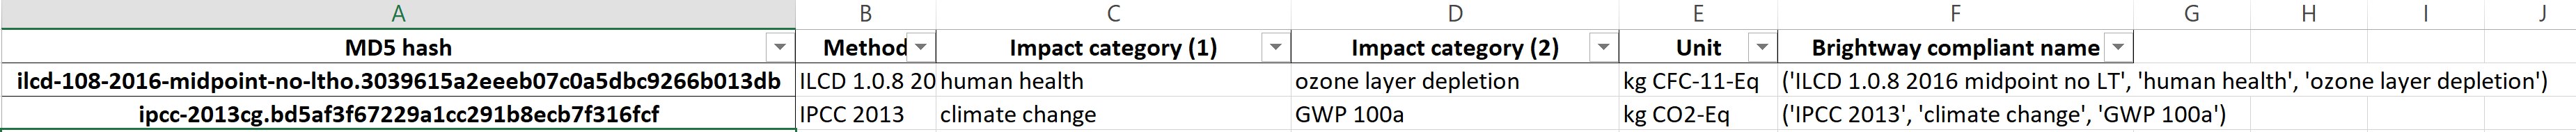

In [31]:
from IPython.display import Image
cwd = os.getcwd()
os.chdir(r'c:/mypy/code/database_wide_monte_carlo/examples/images')
Image('method_search.png')

The file was saved to `C:\mypy\data\my_mcs\db\results\reference_files\methods_shortlist_example.xlsx`

I now import the function:

In [32]:
os.chdir(r'c:/mypy/code/database_wide_monte_carlo')
from LCIA_method_lister import create_list_methods_from_xlsx

And execute it: 

In [33]:
create_list_methods_from_xlsx(base_dir='c:/mypy/data/my_mcs',
                              database_name='db',
                              xlsx_name='methods_shortlist_example.xlsx')

list saved to c:/mypy/data/my_mcs\db\results\reference_files\methods_shortlist_example.pickle


In [34]:
%run calculate_LCIA.py --base_dir=c:/mypy/data/my_mcs --project_name=my_mcs --database_name=db --cpus=8 --method_shortlist_name=methods_shortlist_example

Calculating LCIA score arrays for the following categories:
[('ILCD 1.0.8 2016 midpoint no LT', 'human health', 'ozone layer depletion'), ('IPCC 2013', 'climate change', 'GWP 100a')]


### Final structure
The resulting structure is therefore, for *n* datasets and *m* iterations:  
```bash  
  |-- base_dir   
  |   |-- database      
  |   |   |-- jobs   
  |   |   |   |-- ...
  |   |   |-- results  
  |   |   |   |   |-- reference files
  |   |   |   |   |   |-- ...reference files described above
  |   |   |   |   |-- LCI
  |   |   |   |   |   |-- UUID_1.npy
  |   |   |   |   |   |-- UUID_2.npy  
  |   |   |   |   |   |-- ...
  |   |   |   |   |   |-- UUID_n.npy    
  |   |   |   |   |-- Supply
  |   |   |   |   |   |-- UUID_1.npy
  |   |   |   |   |   |-- UUID_2.npy  
  |   |   |   |   |   |-- ...
  |   |   |   |   |   |-- UUID_n.npy    
  |   |   |   |   |-- Matrices
  |   |   |   |   |   |-- A_matrix.npy
  |   |   |   |   |   |-- B_matrix.npy  
  |   |   |   |   |-- LCIA
  |   |   |   |   |   |-- cml-2001ag.0d5f26ea96ba60424b25b2173464ea8b
  |   |   |   |   |   |   |-- UUID_1.npy
  |   |   |   |   |   |   |-- UUID_2.npy
  |   |   |   |   |   |   |-- ...
  |   |   |   |   |   |   |-- UUID_n.npy
  |   |   |   |   |   |-- recipe-endpoint-ea-wo-ltho.fe0f5b1a20fee2c98494272e36df30f1
  |   |   |   |   |   |   |-- UUID_1.npy
  |   |   |   |   |   |   |-- UUID_2.npy
  |   |   |   |   |   |   |-- ...
  |   |   |   |   |   |   |-- UUID_n.npy
```

## A note on size

While *generating* precalcualted samples for a database as large as ecoinvent v3.4 can take up a lot of disk space, storing LCIA score arrays for streamlined LCA software is much more acceptable. For example:  
  - The size of one iteration is approximately 1 GB. This is split up as follows:  
    - 2 MB for the matrice data  
    - 850 MB for the supply arrays  
    - Just under 150 MB for the LCI arrays  
Note that only the last of these is actually required to generate LCIA score arrays, and that supply arrays, that take up the most space, are probably the least useful objects.  

This means that, for a 5000 iteration sample for all 14889 datasets, LCI arrays will take up just under 1 TB of storage, which can easily fit on an external hard drive. The corresponding supply arrays, on the other hand, will take up over 5 TB, which can be more problematic.  

A 5000 iteration sample for a single dataset and a single impact category takes up 40 KB. Fot the whole database, we are therefore looking at under 600 MB, which is quite acceptable in most circumstances.  

Note that once the LCIA arrays have been generated, everything before it can be deleted.  